In [1]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Conversation Structure") \
    .getOrCreate()




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/10 17:37:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Data 

In [3]:
# Path to the files on local disk
wild_path = "/Users/nicolas/Desktop/MBD/WildChat"
lmsys_path = "/Users/nicolas/Desktop/MBD/Lmsys"
# Load files into a DataFrame or RDD

wild_df = spark.read.parquet(wild_path)
lmsys_df = spark.read.parquet(lmsys_path)

In [4]:
wild_df.show(5)
#wild_df.printSchema()

25/01/10 17:37:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|                     conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|
+--------------------+------------------+-------------------+---------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|             [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|
|b9af1406a2f1593d7...|gpt-3.5-turbo-0613|202

In [5]:
lmsys_df.show(5)
#lmsys_df.printSchema()

+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

### Joining the two datasets while keeping all the columns 

In [6]:
# Combine the two DataFrames, allowing for missing columns
combined_df = wild_df.unionByName(lmsys_df, allowMissingColumns=True)

# Show the combined DataFrame
combined_df.show(20)

25/01/10 17:37:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|   conversation_hash|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_id|
+--------------------+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+---------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;

### Keeping only one column for the conversation ids/hashes 

In [7]:
from pyspark.sql.functions import coalesce

# Create a new column 'conversation_identifier' that contains the non-null value from 'conversation_hash' or 'conversation_id'
combined_df = combined_df.withColumn('conversation_identifier', coalesce(combined_df['conversation_hash'], combined_df['conversation_id']))

# Drop the original columns if you no longer need them
combined_df = combined_df.drop('conversation_hash', 'conversation_id')

# Show the updated DataFrame
combined_df.show(20)

+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+-----------------------+
|             model|          timestamp|                       conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|        country|           hashed_ip|              header|conversation_identifier|
+------------------+-------------------+-----------------------------------+----+--------+--------------------+--------------------+-----+--------+-------------+---------------+--------------------+--------------------+-----------------------+
|gpt-3.5-turbo-0613|2023-09-13 04:14:27|               [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|  United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|   f01a345e668b978b6...|
|gpt-3.5-turbo-0613|2023

### Distribution of conversation lengths (in terms of turns and duration)

In [8]:
%pip install matplotlib
%pip install --upgrade setuptools
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


+-----------------------+---------+
|conversation_identifier|num_turns|
+-----------------------+---------+
|   a2acbe44c4407ba07...|        2|
|   b5eeea7bab5136ad1...|        1|
|   d821aeaef3b7b9575...|        1|
|   dfa0673d159c04303...|        2|
|   32cff4a3fd8705763...|        1|
|   5216fd26d85afc1e2...|        2|
|   5ab9688f08ccb86ac...|        1|
|   f37417dc5f2266b97...|        1|
|   5935b419f10f18810...|        3|
|   98749955536f294f1...|        5|
+-----------------------+---------+
only showing top 10 rows



+-----------------------+--------+
|conversation_identifier|duration|
+-----------------------+--------+
|   00004563856f07fdf...|       0|
|   00004b39283d4d9fa...|    NULL|
|   000050a67cb6aeca0...|       0|
|   00007de6934048b2a...|    NULL|
|   0000a7072bb349ada...|    NULL|
|   0000cba2601f4145b...|    NULL|
|   0000ce95d8dd4aa6b...|    NULL|
|   000104167e5040a7a...|    NULL|
|   0001148819cc42dda...|    NULL|
|   00017ea5ace54487b...|    NULL|
+-----------------------+--------+
only showing top 10 rows



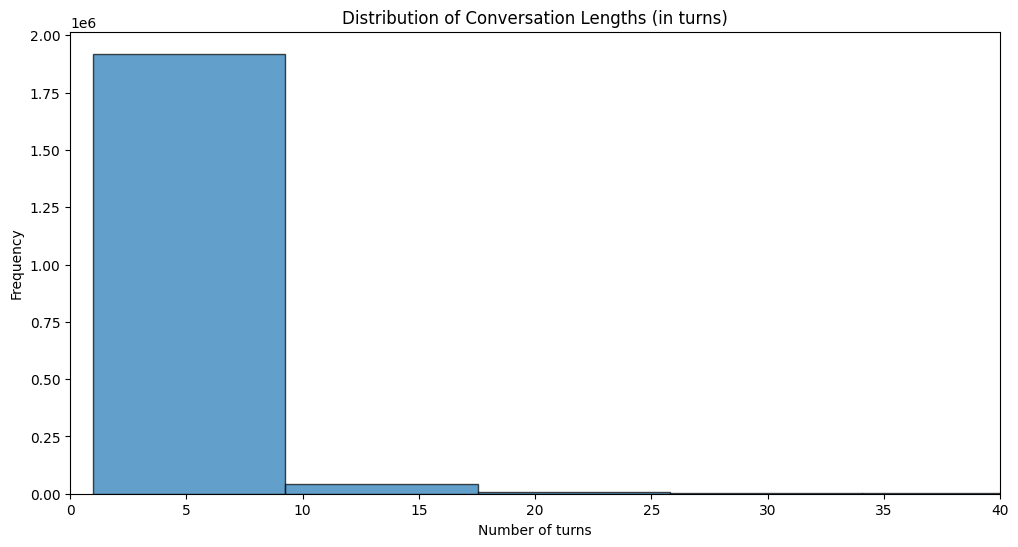

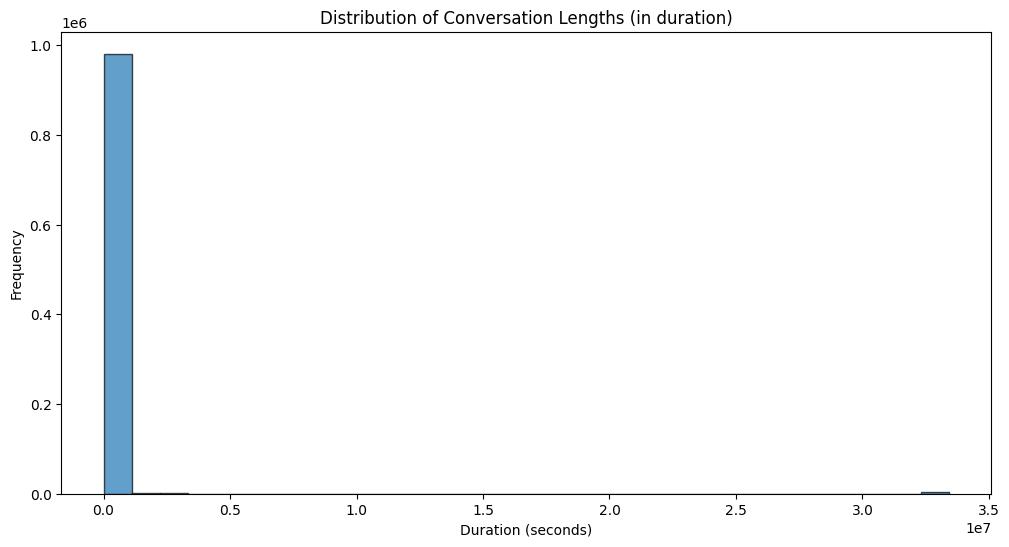

In [9]:

from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, min, max, unix_timestamp, to_timestamp, first, expr

# Ensure the timestamp column is of type TIMESTAMP
combined_df = combined_df.withColumn("timestamp", expr("timestamp"))

# Calculate the number of turns per conversation using the existing 'turn' column
conversation_turns_df = combined_df.groupBy("conversation_identifier").agg(max("turn").alias("num_turns"))

# Calculate the duration of each conversation
window_spec = Window.partitionBy("conversation_identifier")
conversation_duration_df = combined_df.withColumn("start_time", min("timestamp").over(window_spec)) \
                                      .withColumn("end_time", max("timestamp").over(window_spec)) \
                                      .withColumn("duration", unix_timestamp(col("end_time")) - unix_timestamp(col("start_time")))

# Show the results
conversation_turns_df.select("conversation_identifier", "num_turns").show(10)
conversation_duration_df.select("conversation_identifier", "duration").show(10)

# Visualize the distribution of conversation lengths in turns and duration
# Convert to Pandas DataFrame for visualization
turns_pd_df = conversation_turns_df.select("num_turns").toPandas()
duration_pd_df = conversation_duration_df.select("duration").toPandas()

# Plot the distribution of conversation lengths in turns
plt.figure(figsize=(12, 6))
plt.hist(turns_pd_df["num_turns"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Conversation Lengths (in turns)")
plt.xlabel("Number of turns")
plt.ylabel("Frequency")
# Adjust the scales of the graphs
plt.xlim(0, 40)
plt.show()

# Plot the distribution of conversation lengths in duration
plt.figure(figsize=(12, 6))
plt.hist(duration_pd_df["duration"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Conversation Lengths (in duration)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

### User message length across different stages of conversation

In [14]:
combined_df.select("conversation_identifier", "timestamp").filter(col("timestamp").isNull()).show()
combined_df = combined_df.filter(col("timestamp").isNotNull())

+-----------------------+---------+
|conversation_identifier|timestamp|
+-----------------------+---------+
|   c20948192699451b8...|     NULL|
|   8b02aa2df44847a1b...|     NULL|
|   c18f3612fac140cb9...|     NULL|
|   d1fabb62e3364665a...|     NULL|
|   b2da335248f04e439...|     NULL|
|   2dbd0eff0aa543bba...|     NULL|
|   58b648dff2b040d2a...|     NULL|
|   4e211908c506467b8...|     NULL|
|   fb24c174e35149ecb...|     NULL|
|   7a89cf2af95a4fa99...|     NULL|
|   bc82b444362b46969...|     NULL|
|   1073c7201c544d489...|     NULL|
|   289c9947ebe5484ea...|     NULL|
|   46ebfbd78d904561a...|     NULL|
|   c78d9105ad484c71b...|     NULL|
|   2dc4de75be894ef09...|     NULL|
|   afb3f215f7144687b...|     NULL|
|   a06eb9e7de0046508...|     NULL|
|   1e83005a7317490bb...|     NULL|
|   ce8d3b8b273248098...|     NULL|
+-----------------------+---------+
only showing top 20 rows



+-----------+------------------+
|turn_number|avg_content_length|
+-----------+------------------+
|         31|             390.5|
|         85|229.06666666666666|
|         65|357.03478260869565|
|         53|401.97136563876654|
|         78| 206.6818181818182|
|        108| 99.79166666666667|
|         34|301.35032220269477|
|        101|452.57894736842104|
|         81| 294.6198347107438|
|         28|353.73674785100286|
+-----------+------------------+
only showing top 10 rows



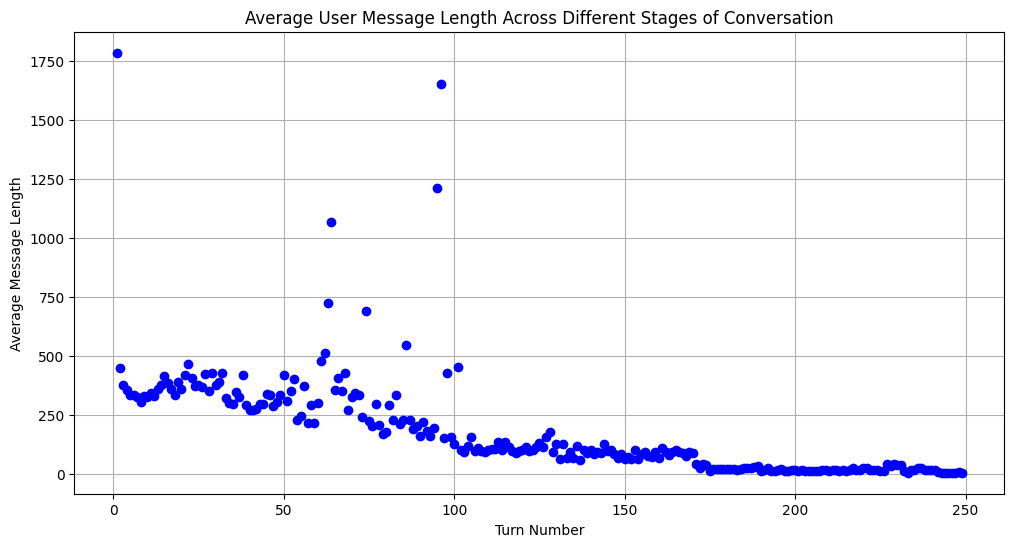

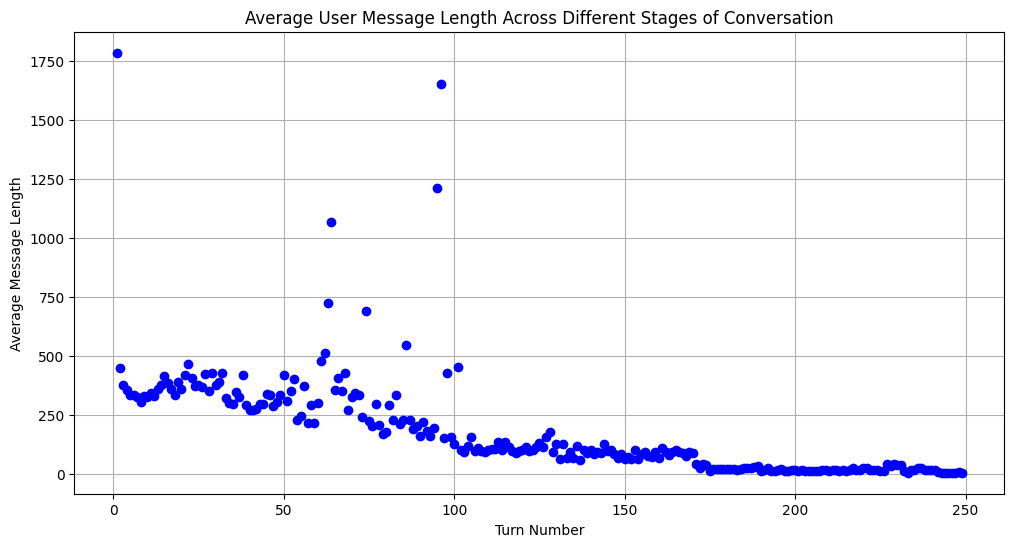

In [16]:
from pyspark.sql.functions import col, explode, size, length
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window



# Explode the conversation array to have one row per message
exploded_df = combined_df.withColumn("message", explode("conversation"))
#exploded_df.show(5)


#exploded_df.select("message").show(1, truncate=False)
#exploded_df.select("conversation").show(1, truncate=False)

# Filter messages where role is "user"
user_messages_df = exploded_df.filter(col("message.role") == "user")
#user_messages_df.show(5)

# Add a column with the content of the message
user_messages_df = user_messages_df.withColumn("content", col("message.content")) 
 
# Add a column with the turn number for each message within a conversation
window_spec = Window.partitionBy("conversation_identifier").orderBy("timestamp")
user_messages_df = user_messages_df.withColumn("turn_number", row_number().over(window_spec))



# Calculate the length of each content
user_messages_df = user_messages_df.withColumn("content_length", length(col("content")))
# Calculate the average content length per turn
avg_content_length_per_turn_df = user_messages_df.groupBy("turn_number").agg({"content_length": "avg"}).withColumnRenamed("avg(content_length)", "avg_content_length")

# Show the results
avg_content_length_per_turn_df.show(10)
# Filter to keep only turns up to the value 249
filtered_avg_message_length_df = avg_content_length_per_turn_df.filter(col("turn_number") <= 249)

# Store the result in another DataFrame
avg_message_length_df = filtered_avg_message_length_df

# Convert to Pandas DataFrame for visualization
avg_message_length_pd_df = avg_message_length_df.select("turn_number", "avg_content_length").toPandas()

# Plot the average message length across different stages of conversation.
plt.figure(figsize=(12, 6))
plt.plot(avg_message_length_pd_df["turn_number"], avg_message_length_pd_df["avg_content_length"], marker='o', linestyle='', color='b')
plt.title("Average User Message Length Across Different Stages of Conversation")
plt.xlabel("Turn Number")
plt.ylabel("Average Message Length")
plt.grid(True)
plt.show()

